In [ ]:
import sys
from pathlib import Path
notebook_dir = Path('/home/chan21/idim-debug-spectra/notebooks')
#notebook_dir = Path().absolute()
while not (notebook_dir / 'src').exists():
    notebook_dir = notebook_dir.parent
    
if str(notebook_dir) not in sys.path:
    sys.path.append(str(notebook_dir))

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from pathlib import Path
from src.utils._config import *
from src.utils._io import *
from src.utils._paths import *
from src.spectra._definition import *
from src.utils.plot import *
import argparse
from tqdm import tqdm
import pandas as pd
import h5py
import itertools

mpl.rcParams.update(DEFAULT_MATPLOTLIBRC)
sns.set_theme(style="ticks", rc=DEFAULT_MATPLOTLIBRC, context="poster")

path = Path('/home/chan21/idim-debug-spectra/results/recon_occipital_functional/')
#path = Path('/home/chan21/idim-debug-spectra/results/pca_occipital_functional/')
config = AnalysisConfig.from_yaml(path / "config.yaml")
subjects = config.subjects
h5_path = path / 'eigenspectra_sub-NSD103_sub-NSD104.h5'

movies = ['iteration', 'defeat', 'growth', 'lemonade']
matrices = {}
pairwise_subjects = list(itertools.combinations(subjects, 2))
for movie in movies:
    matrix = np.zeros((len(subjects), len(subjects)))
    for target_subjects in pairwise_subjects:
        # change h5_path accordingly
        h5_path = path / f'eigenspectra_{target_subjects[0]}_{target_subjects[1]}.h5'
        with h5py.File(h5_path, 'r') as h5f:
            i = subjects.index(target_subjects[0])
            j = subjects.index(target_subjects[1])
            key = f"data/{target_subjects[0]}_{target_subjects[1]}_{movie}"
            if key in h5f:
                if type(h5f[key]['observed'][()]) == np.ndarray:
                    matrix[i, j] = h5f[key]['observed'][()].mean()
                else:
                    matrix[i, j] = h5f[key]['observed'][()]     
    matrices[movie] = matrix



# Take upper triangles
for movie in movies:
    matrices[movie] = np.triu(matrices[movie], k=1)

# Get correlations between matrices
correlations = {}
for movie in movies:
    correlations[movie] = np.corrcoef(matrices[movie].flatten(), matrices['iteration'].flatten())[0, 1]

# Visualize matrices and correlations
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

for i, movie in enumerate(movies):
    ax = axes[i]
    sns.heatmap(matrices[movie], ax=ax, cmap='viridis', square=True, cbar=False)
    ax.set_title(f"{movie} (corr: {correlations[movie]:.2f})")
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('Subject')
    ax.set_ylabel('Subject')

plt.tight_layout()
plt.show()



# ISC
matrices_isc = {}
h5_path = Path('/home/chan21/idim-debug-spectra/results/isc_occipital_functional/eigenspectra.h5')
for movie in movies:
    matrix = np.zeros((len(subjects), len(subjects)))
    with h5py.File(h5_path, 'r') as h5f:
        for i, i_subject in enumerate(subjects):
            for j, j_subject in enumerate(subjects[i+1:], i+1):
                key = f"data/{i_subject}_{j_subject}_{movie}"
                if key in h5f:
                    if type(h5f[key]['observed'][()]) == np.ndarray:
                        matrix[i, j] = h5f[key]['observed'][()].mean()
                    else:
                        matrix[i, j] = h5f[key]['observed'][()]     
    matrices_isc[movie] = matrix


# Take upper triangles
for movie in movies:
    matrices_isc[movie] = np.triu(matrices_isc[movie], k=1)

# Get correlations between matrices
correlations = {}
for movie in movies:
    correlations[movie] = np.corrcoef(matrices_isc[movie].flatten(), matrices_isc['iteration'].flatten())[0, 1]

# Visualize matrices and correlations
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

for i, movie in enumerate(movies):
    ax = axes[i]
    sns.heatmap(matrices_isc[movie], ax=ax, cmap='viridis', square=True, cbar=False)
    ax.set_title(f"{movie} (corr: {correlations[movie]:.2f})")
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('Subject')
    ax.set_ylabel('Subject')

plt.tight_layout()
plt.show()
    

matrices_even = np.zeros((len(subjects), len(subjects)))
matrices_odd = np.zeros((len(subjects), len(subjects)))
matrices_isc_even = np.zeros((len(subjects), len(subjects)))
matrices_isc_odd = np.zeros((len(subjects), len(subjects)))
even_movies = movies[::2]
odd_movies = movies[1::2]

# average even and odd movies
matrices_even = np.nanmean([matrices[m] for m in even_movies], axis=0)
matrices_odd = np.nanmean([matrices[m] for m in odd_movies], axis=0)
matrices_isc_even = np.nanmean([matrices_isc[m] for m in even_movies], axis=0)
matrices_isc_odd = np.nanmean([matrices_isc[m] for m in odd_movies], axis=0)

# z-score matrices
matrices_even = (matrices_even - matrices_even.mean()) / matrices_even.std()
matrices_odd = (matrices_odd - matrices_odd.mean()) / matrices_odd.std()
matrices_isc_even = (matrices_isc_even - matrices_isc_even.mean()) / matrices_isc_even.std()
matrices_isc_odd = (matrices_isc_odd - matrices_isc_odd.mean()) / matrices_isc_odd.std()

def get_upper_triangle(matrix: np.ndarray) -> np.ndarray:
    """Extract upper triangle values from a matrix, excluding diagonal."""
    mask = np.triu_indices(matrix.shape[0], k=1)
    return matrix[mask]

# Take upper triangles
triu_even = get_upper_triangle(matrices_even)
triu_odd = get_upper_triangle(matrices_odd)
triu_isc_even = get_upper_triangle(matrices_isc_even)
triu_isc_odd = get_upper_triangle(matrices_isc_odd)

# # Get correlations (triu-even vs triu-odd, triu-even vs. triu-isc-odd, triu_odd vs. triu-isc-even)
# correlations = {}
# correlations['high_even_high_odd'] = np.corrcoef(triu_isc_even.flatten(), triu_isc_odd.flatten())[0, 1]
# correlations['high_even_low_even'] = np.corrcoef(triu_isc_even.flatten(), triu_odd.flatten())[0, 1]
# correlations['low_even_low_odd'] = np.corrcoef(triu_odd.flatten(), triu_isc_even.flatten())[0, 1]

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import spearmanr

# Create the figure with subplots - adding more spacing between plots
fig, axes = plt.subplots(2, 2, figsize=(12, 12), gridspec_kw={'wspace': 0.3, 'hspace': 0.3})

# Calculate the correlations
# correlations = {
#     'high_even_high_odd': np.corrcoef(triu_isc_even.flatten(), triu_isc_odd.flatten())[0, 1],
#     'high_even_low_odd': np.corrcoef(triu_isc_even.flatten(), triu_odd.flatten())[0, 1],
#     'low_even_low_odd': np.corrcoef(triu_even.flatten(), triu_odd.flatten())[0, 1]
# }
correlations = {
    'high_even_high_odd': spearmanr(triu_isc_even.flatten(), triu_isc_odd.flatten())[0],
    'high_even_low_odd': spearmanr(triu_isc_even.flatten(), triu_odd.flatten())[0],
    'low_even_low_odd': spearmanr(triu_even.flatten(), triu_odd.flatten())[0]
}

# Define colormap
cmap = plt.cm.RdBu_r
vmin, vmax = 0, 1

# Plot the heatmaps
# Top row - high-D
sns.heatmap(matrices_isc_even, ax=axes[0, 0], cmap=cmap, vmin=vmin, vmax=vmax,
            square=True, cbar=False)
sns.heatmap(matrices_isc_odd, ax=axes[0, 1], cmap=cmap, vmin=vmin, vmax=vmax,
            square=True, cbar=False)

# Bottom row - low-D
sns.heatmap(matrices_even, ax=axes[1, 0], cmap=cmap, vmin=vmin, vmax=vmax,
            square=True, cbar=False)
sns.heatmap(matrices_odd, ax=axes[1, 1], cmap=cmap, vmin=vmin, vmax=vmax,
            square=True, cbar=False)

# Remove axes ticks
for ax in axes.flatten():
    ax.set_xticks([])
    ax.set_yticks([])

# Add row labels on the left with increased font size
axes[0, 0].set_ylabel('high-D', fontsize=18)
axes[1, 0].set_ylabel('low-D', fontsize=18)

# Add column labels on top with increased font size
axes[0, 0].set_title('even', fontsize=18)
axes[0, 1].set_title('odd', fontsize=18)

# Create colorbar
cbar_ax = fig.add_axes([0.93, 0.15, 0.02, 0.7])
cb = plt.colorbar(plt.cm.ScalarMappable(norm=plt.Normalize(vmin=vmin, vmax=vmax), cmap=cmap), 
                 cax=cbar_ax)
cb.set_ticks([0.00, 0.25, 0.50, 0.75, 1.00])
#cbar_ax.set_title('Pearson\ncorrelation', fontsize=16)

# Apply tight layout first
plt.tight_layout(rect=[0, 0, 0.9, 0.95])

# Get axis positions after tight_layout
ax00_pos = axes[0, 0].get_position()
ax01_pos = axes[0, 1].get_position()
ax10_pos = axes[1, 0].get_position()
ax11_pos = axes[1, 1].get_position()

# Create a separate axes for drawing lines
line_ax = fig.add_axes([0, 0, 1, 1], frameon=False)
line_ax.set_xlim(0, 1)
line_ax.set_ylim(0, 1)
line_ax.axis('off')  # Hide axes

# Draw the horizontal line between top matrices
line_ax.plot(
    [ax00_pos.x1, ax01_pos.x0], 
    [ax00_pos.y0 + ax00_pos.height/2, ax01_pos.y0 + ax01_pos.height/2],
    'k-', linewidth=2
)

# Draw the horizontal line between bottom matrices
line_ax.plot(
    [ax10_pos.x1, ax11_pos.x0], 
    [ax10_pos.y0 + ax10_pos.height/2, ax11_pos.y0 + ax11_pos.height/2],
    'k-', linewidth=2
)

# Draw the diagonal line from high-D even to low-D odd (CORRECTED)
line_ax.plot(
    [ax00_pos.x0 + ax00_pos.width/2, ax11_pos.x0 + ax11_pos.width/2], 
    [ax00_pos.y0 + ax00_pos.height/2, ax11_pos.y0 + ax11_pos.height/2],
    'k-', linewidth=2
)

# Add correlation text labels
# Top horizontal
mid_x_top = (ax00_pos.x1 + ax01_pos.x0) / 2
mid_y_top = ax00_pos.y0 + ax00_pos.height/2
fig.text(mid_x_top, mid_y_top + 0.02, f"r = {correlations['high_even_high_odd']:.2f}", 
        ha='center', va='bottom', fontsize=14, fontweight='bold')

# Bottom horizontal
mid_x_bottom = (ax10_pos.x1 + ax11_pos.x0) / 2
mid_y_bottom = ax10_pos.y0 + ax10_pos.height/2
fig.text(mid_x_bottom, mid_y_bottom + 0.02, f"r = {correlations['low_even_low_odd']:.2f}", 
        ha='center', va='bottom', fontsize=14, fontweight='bold')

# Diagonal from high-D even to low-D odd (CORRECTED)
mid_x_diag = (ax00_pos.x0 + ax00_pos.width/2 + ax11_pos.x0 + ax11_pos.width/2) / 2
mid_y_diag = (ax00_pos.y0 + ax00_pos.height/2 + ax11_pos.y0 + ax11_pos.height/2) / 2
fig.text(mid_x_diag + 0.03, mid_y_diag, f"r = {correlations['high_even_low_odd']:.2f}", 
        ha='left', va='center', fontsize=14, fontweight='bold')

#plt.savefig('correlation_matrices_final_fixed.png', dpi=300, bbox_inches='tight')
plt.show()

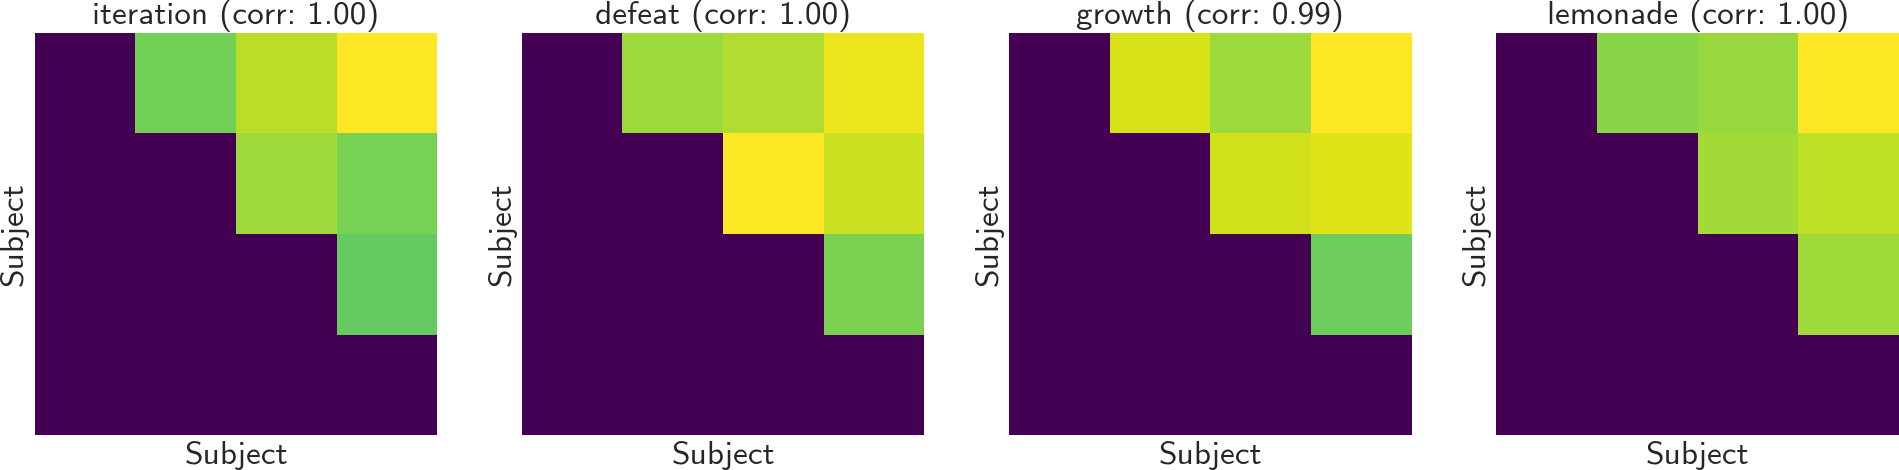

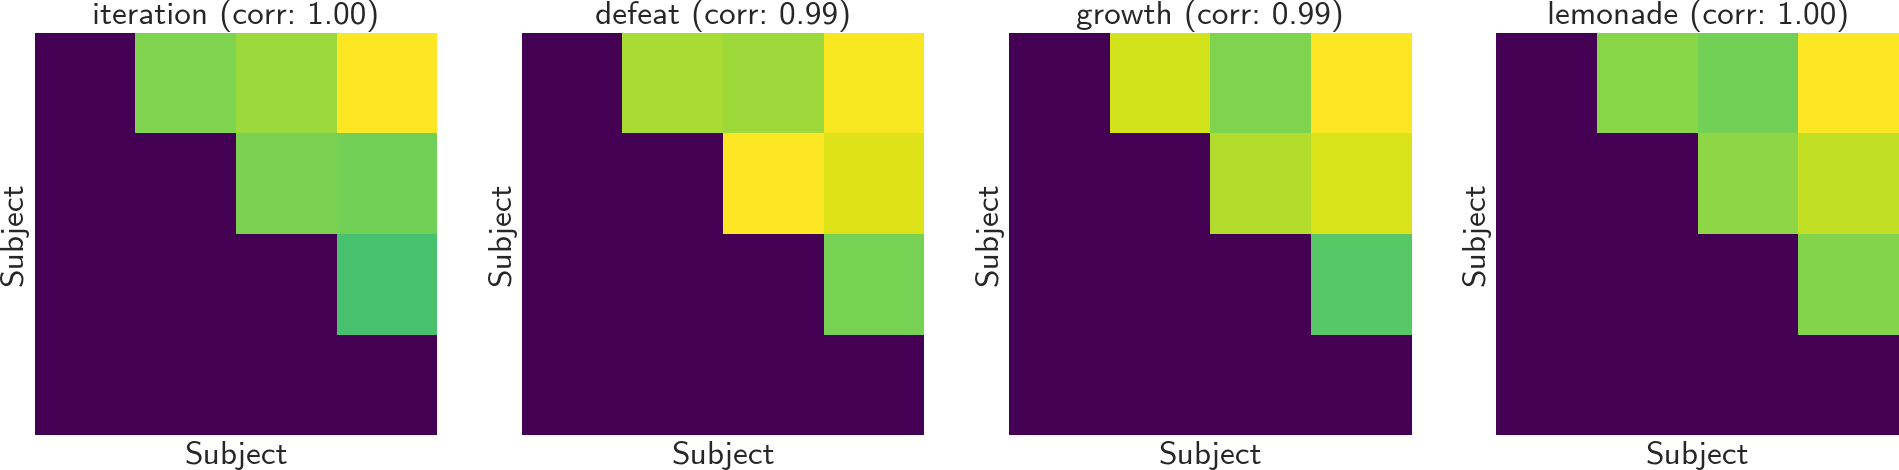

/home/chan21/.conda/envs/bonner-libraries/lib/python3.11/site-packages/seaborn/utils.py:84: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.draw()
/home/chan21/.conda/envs/bonner-libraries/lib/python3.11/site-packages/seaborn/utils.py:84: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.draw()
/home/chan21/.conda/envs/bonner-libraries/lib/python3.11/site-packages/seaborn/utils.py:84: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.draw()
/home/chan21/.conda/envs/bonner-libraries/lib/python3.11/site-packages/seaborn/utils.py:84: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.draw()
/tmp/ipykernel_1373/3111949268.py:59: UserWarning: This figure includes Axes that are not compatible

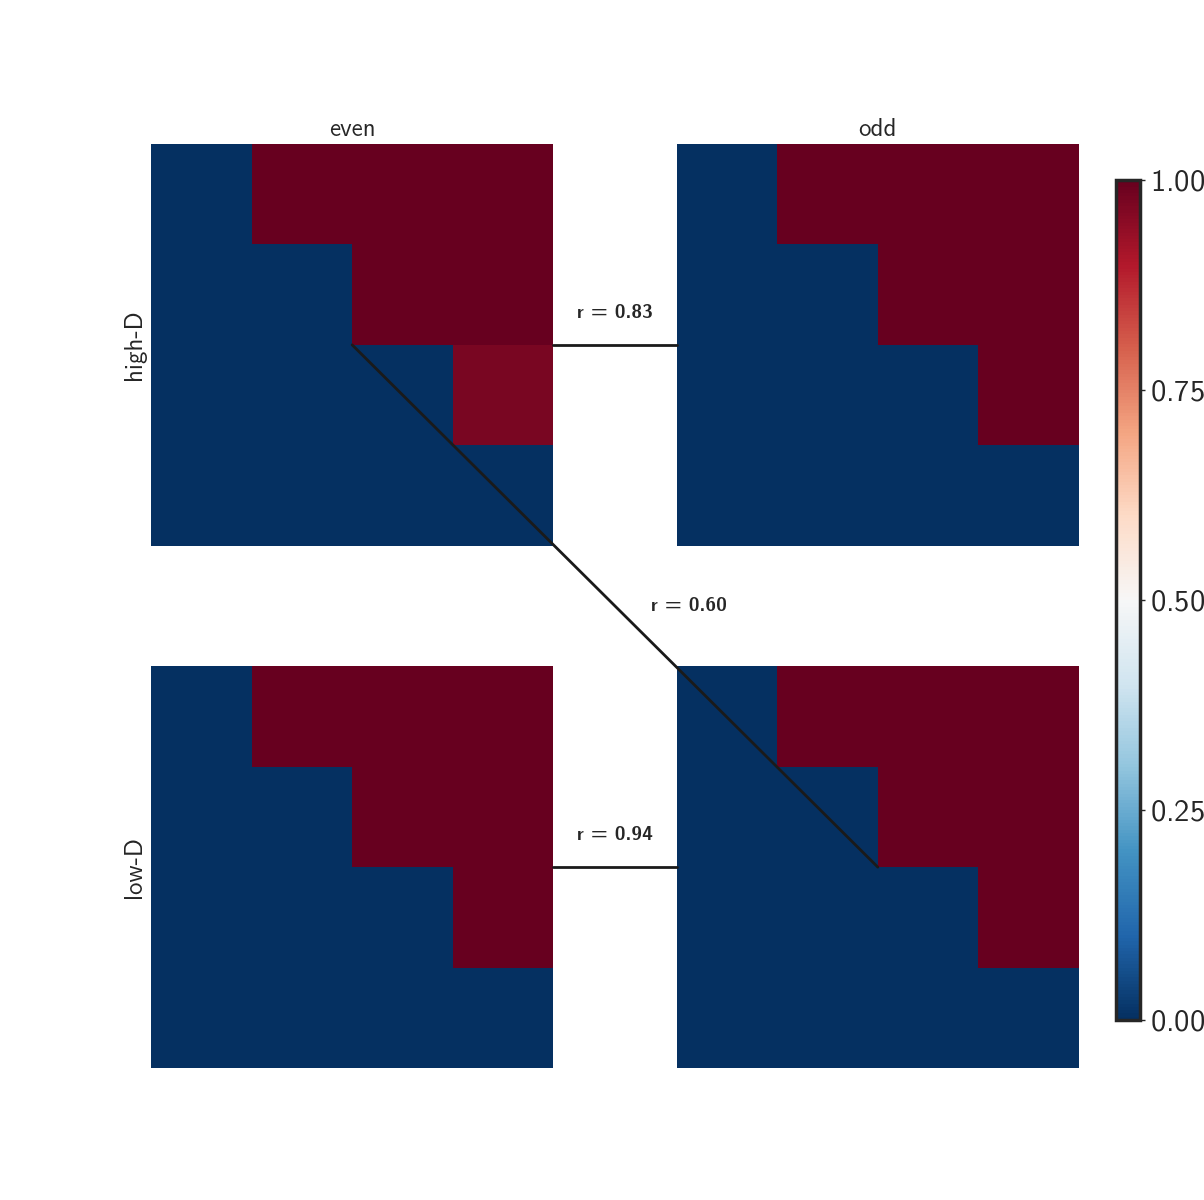

In [ ]:
# why is the base isc correlation so high? let's try partialing out noise


# try cross-decomposition for reconstruction instead of pca?

/home/chan21/.conda/envs/bonner-libraries/lib/python3.11/site-packages/seaborn/utils.py:84: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.draw()
/home/chan21/.conda/envs/bonner-libraries/lib/python3.11/site-packages/seaborn/utils.py:84: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.draw()
/home/chan21/.conda/envs/bonner-libraries/lib/python3.11/site-packages/seaborn/utils.py:84: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.draw()
/home/chan21/.conda/envs/bonner-libraries/lib/python3.11/site-packages/seaborn/utils.py:84: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.draw()
/tmp/ipykernel_35567/546456789.py:139: UserWarning: This figure includes Axes that are not compatibl

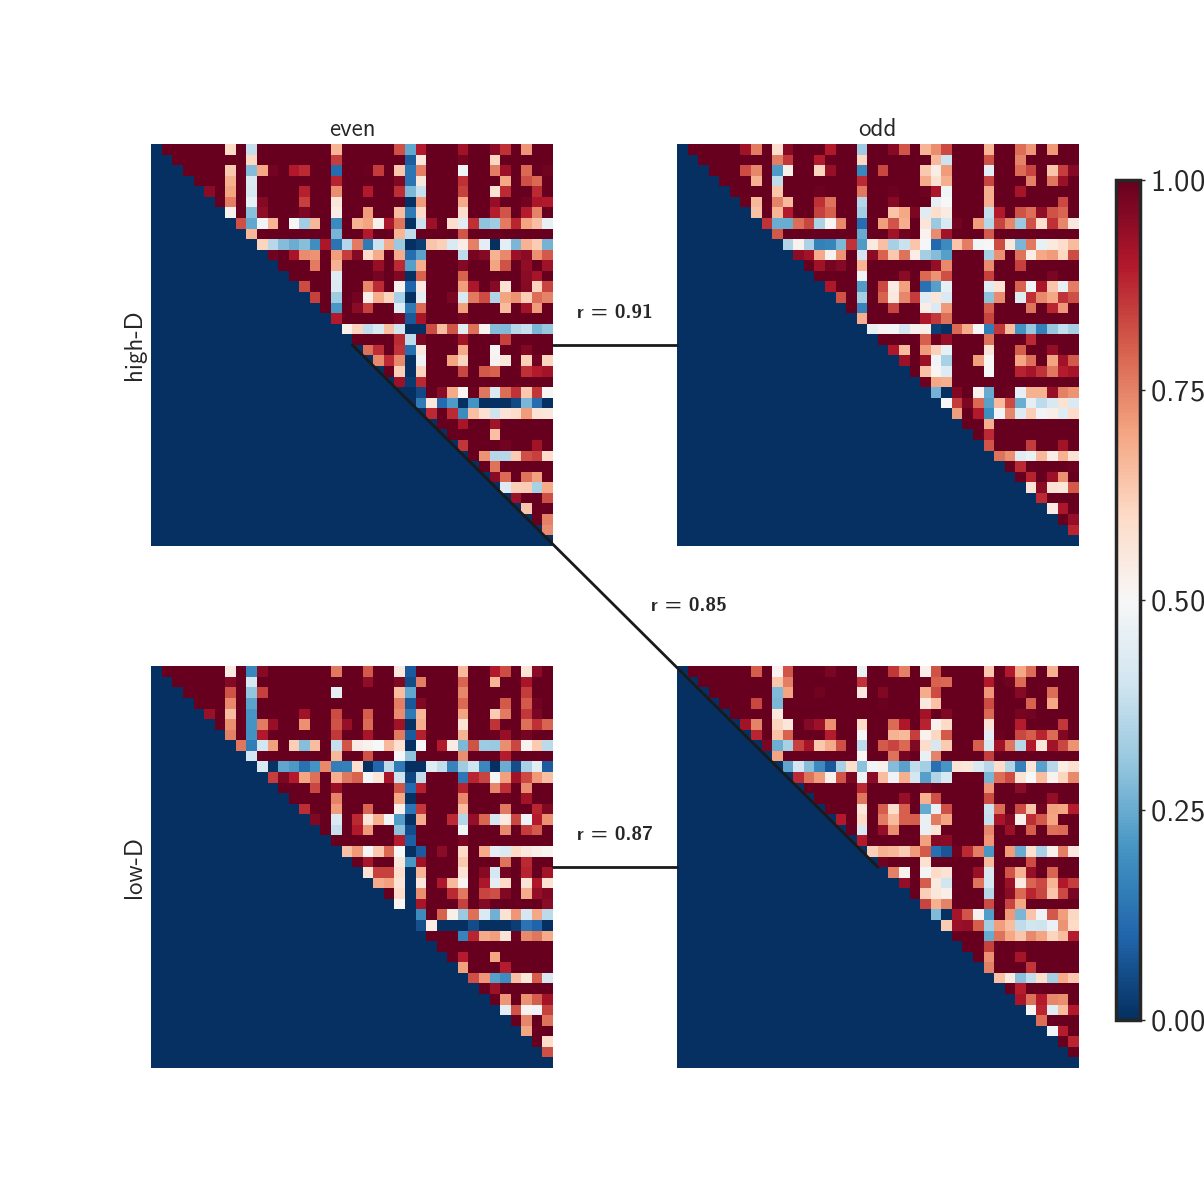

In [4]:
import sys
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import h5py
import itertools
from scipy.stats import spearmanr

# Path setup
notebook_dir = Path('/home/chan21/idim-debug-spectra/notebooks')
while not (notebook_dir / 'src').exists():
    notebook_dir = notebook_dir.parent
if str(notebook_dir) not in sys.path:
    sys.path.append(str(notebook_dir))

from src.utils._config import *
from src.utils._io import *
from src.utils._paths import *
from src.spectra._definition import *
from src.utils.plot import *

# Set plotting style
plt.rcParams.update(DEFAULT_MATPLOTLIBRC)
sns.set_theme(style="ticks", rc=DEFAULT_MATPLOTLIBRC, context="poster")

# Load configuration
path = Path('/home/chan21/idim-debug-spectra/results/pca_occipital_functional/')
config = AnalysisConfig.from_yaml(path / "config.yaml")
subjects = config.subjects
movies = ['iteration', 'defeat', 'growth', 'lemonade']

def get_upper_triangle(matrix):
    """Extract upper triangle values from a matrix, excluding diagonal."""
    mask = np.triu_indices(matrix.shape[0], k=1)
    return matrix[mask]

def load_matrices(base_path, is_isc=False):
    """Load matrices from HDF5 files."""
    matrices = {}
    
    if is_isc:
        h5_path = Path('/home/chan21/idim-debug-spectra/results/isc_occipital_functional/eigenspectra.h5')
        for movie in movies:
            matrix = np.zeros((len(subjects), len(subjects)))
            with h5py.File(h5_path, 'r') as h5f:
                for i, i_subject in enumerate(subjects):
                    for j, j_subject in enumerate(subjects[i+1:], i+1):
                        key = f"data/{i_subject}_{j_subject}_{movie}"
                        if key in h5f:
                            value = h5f[key]['observed'][()]
                            matrix[i, j] = value.mean() if isinstance(value, np.ndarray) else value
            matrices[movie] = np.triu(matrix, k=1)
    else:
        pairwise_subjects = list(itertools.combinations(subjects, 2))
        for movie in movies:
            matrix = np.zeros((len(subjects), len(subjects)))
            for target_subjects in pairwise_subjects:
                h5_path = base_path / f'eigenspectra_{target_subjects[0]}_{target_subjects[1]}.h5'
                with h5py.File(h5_path, 'r') as h5f:
                    i = subjects.index(target_subjects[0])
                    j = subjects.index(target_subjects[1])
                    key = f"data/{target_subjects[0]}_{target_subjects[1]}_{movie}"
                    if key in h5f:
                        value = h5f[key]['observed'][()]
                        matrix[i, j] = value.mean() if isinstance(value, np.ndarray) else value
            matrices[movie] = np.triu(matrix, k=1)
    
    return matrices

# Load standard matrices and ISC matrices
matrices = load_matrices(path)
matrices_isc = load_matrices(path, is_isc=True)

# Create even/odd splits
even_movies = movies[::2]  # iteration, growth
odd_movies = movies[1::2]  # defeat, lemonade

# Average and normalize matrices
def process_split_matrices(matrices_dict, movie_indices):
    """Average and z-score matrices for given movie indices."""
    avg_matrix = np.nanmean([matrices_dict[movies[i]] for i in movie_indices], axis=0)
    return (avg_matrix - avg_matrix.mean()) / avg_matrix.std()

# Process matrices for each split
matrices_even = process_split_matrices(matrices, [0, 2])  # iteration, growth
matrices_odd = process_split_matrices(matrices, [1, 3])   # defeat, lemonade
matrices_isc_even = process_split_matrices(matrices_isc, [0, 2])
matrices_isc_odd = process_split_matrices(matrices_isc, [1, 3])

# Extract upper triangles for correlation
triu_even = get_upper_triangle(matrices_even)
triu_odd = get_upper_triangle(matrices_odd)
triu_isc_even = get_upper_triangle(matrices_isc_even)
triu_isc_odd = get_upper_triangle(matrices_isc_odd)

# Calculate Spearman correlations
correlations = {
    'high_even_high_odd': spearmanr(triu_isc_even, triu_isc_odd)[0],
    'high_even_low_odd': spearmanr(triu_isc_even, triu_odd)[0],
    'low_even_low_odd': spearmanr(triu_even, triu_odd)[0]
}

# Create visualization
def plot_correlation_matrices():
    """Create correlation matrices visualization with connecting lines."""
    fig, axes = plt.subplots(2, 2, figsize=(12, 12), gridspec_kw={'wspace': 0.3, 'hspace': 0.3})
    
    # Define colormap
    cmap = plt.cm.RdBu_r
    vmin, vmax = 0, 1
    
    # Plot heatmaps
    matrices_to_plot = [
        [matrices_isc_even, matrices_isc_odd],  # Top row (high-D)
        [matrices_even, matrices_odd]           # Bottom row (low-D)
    ]
    
    for i in range(2):
        for j in range(2):
            sns.heatmap(matrices_to_plot[i][j], ax=axes[i, j], cmap=cmap, 
                        vmin=vmin, vmax=vmax, square=True, cbar=False)
            axes[i, j].set_xticks([])
            axes[i, j].set_yticks([])
    
    # Add row and column labels
    axes[0, 0].set_ylabel('high-D', fontsize=18)
    axes[1, 0].set_ylabel('low-D', fontsize=18)
    axes[0, 0].set_title('even', fontsize=18)
    axes[0, 1].set_title('odd', fontsize=18)
    
    # Add colorbar
    cbar_ax = fig.add_axes([0.93, 0.15, 0.02, 0.7])
    cb = plt.colorbar(plt.cm.ScalarMappable(norm=plt.Normalize(vmin=vmin, vmax=vmax), cmap=cmap), 
                     cax=cbar_ax)
    cb.set_ticks([0.00, 0.25, 0.50, 0.75, 1.00])
    
    # Apply tight layout
    plt.tight_layout(rect=[0, 0, 0.9, 0.95])
    
    # Get axis positions for drawing lines
    ax_pos = [[ax.get_position() for ax in row] for row in axes]
    
    # Create a separate axes for drawing lines
    line_ax = fig.add_axes([0, 0, 1, 1], frameon=False)
    line_ax.set_xlim(0, 1)
    line_ax.set_ylim(0, 1)
    line_ax.axis('off')
    
    # Draw connecting lines and add correlation labels
    # Top horizontal line (high-even to high-odd)
    mid_x_top = (ax_pos[0][0].x1 + ax_pos[0][1].x0) / 2
    mid_y_top = ax_pos[0][0].y0 + ax_pos[0][0].height/2
    line_ax.plot(
        [ax_pos[0][0].x1, ax_pos[0][1].x0], 
        [mid_y_top, mid_y_top],
        'k-', linewidth=2
    )
    fig.text(mid_x_top, mid_y_top + 0.02, f"r = {correlations['high_even_high_odd']:.2f}", 
            ha='center', va='bottom', fontsize=14, fontweight='bold')
    
    # Bottom horizontal line (low-even to low-odd)
    mid_x_bottom = (ax_pos[1][0].x1 + ax_pos[1][1].x0) / 2
    mid_y_bottom = ax_pos[1][0].y0 + ax_pos[1][0].height/2
    line_ax.plot(
        [ax_pos[1][0].x1, ax_pos[1][1].x0], 
        [mid_y_bottom, mid_y_bottom],
        'k-', linewidth=2
    )
    fig.text(mid_x_bottom, mid_y_bottom + 0.02, f"r = {correlations['low_even_low_odd']:.2f}", 
            ha='center', va='bottom', fontsize=14, fontweight='bold')
    
    # Diagonal line (high-even to low-odd)
    mid_x_diag = (ax_pos[0][0].x0 + ax_pos[0][0].width/2 + ax_pos[1][1].x0 + ax_pos[1][1].width/2) / 2
    mid_y_diag = (ax_pos[0][0].y0 + ax_pos[0][0].height/2 + ax_pos[1][1].y0 + ax_pos[1][1].height/2) / 2
    line_ax.plot(
        [ax_pos[0][0].x0 + ax_pos[0][0].width/2, ax_pos[1][1].x0 + ax_pos[1][1].width/2], 
        [ax_pos[0][0].y0 + ax_pos[0][0].height/2, ax_pos[1][1].y0 + ax_pos[1][1].height/2],
        'k-', linewidth=2
    )
    fig.text(mid_x_diag + 0.03, mid_y_diag, f"r = {correlations['high_even_low_odd']:.2f}", 
            ha='left', va='center', fontsize=14, fontweight='bold')
    
    return fig

# Generate and display the plot
fig = plot_correlation_matrices()
plt.show()

Processing ROI: occipital


/home/chan21/.conda/envs/bonner-libraries/lib/python3.11/site-packages/seaborn/utils.py:84: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.draw()
/home/chan21/.conda/envs/bonner-libraries/lib/python3.11/site-packages/seaborn/utils.py:84: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.draw()
/home/chan21/.conda/envs/bonner-libraries/lib/python3.11/site-packages/seaborn/utils.py:84: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.draw()
/home/chan21/.conda/envs/bonner-libraries/lib/python3.11/site-packages/seaborn/utils.py:84: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.draw()
/tmp/ipykernel_45893/405156537.py:196: UserWarning: This figure includes Axes that are not compatibl

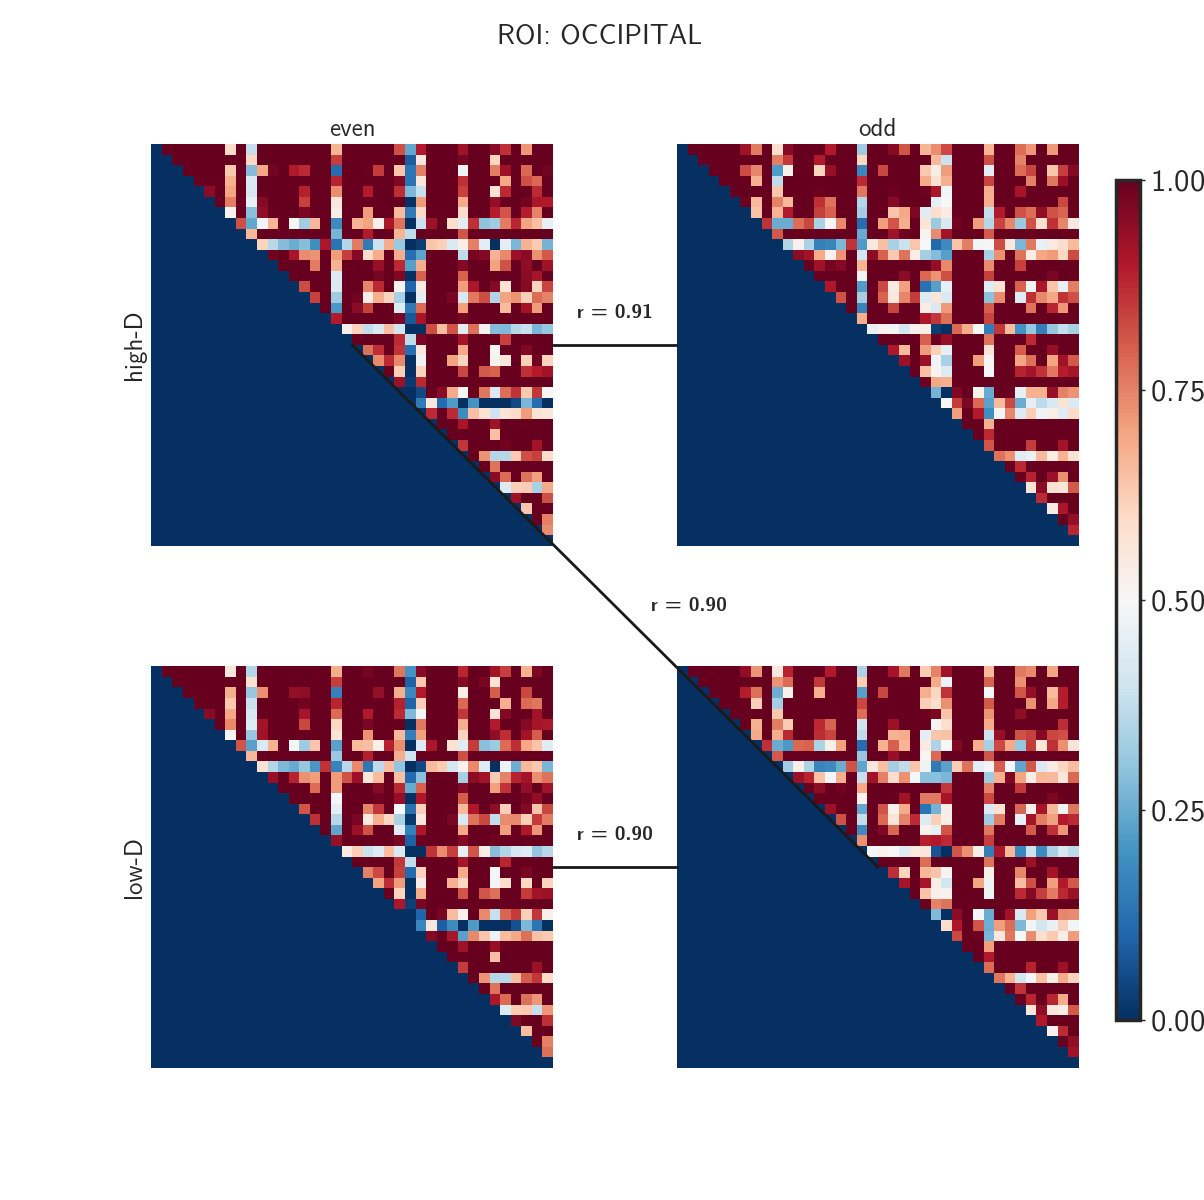

Completed processing for occipital
Processing ROI: temporal


/home/chan21/.conda/envs/bonner-libraries/lib/python3.11/site-packages/seaborn/utils.py:84: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.draw()
/home/chan21/.conda/envs/bonner-libraries/lib/python3.11/site-packages/seaborn/utils.py:84: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.draw()
/home/chan21/.conda/envs/bonner-libraries/lib/python3.11/site-packages/seaborn/utils.py:84: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.draw()
/home/chan21/.conda/envs/bonner-libraries/lib/python3.11/site-packages/seaborn/utils.py:84: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.draw()
/tmp/ipykernel_45893/405156537.py:196: UserWarning: This figure includes Axes that are not compatibl

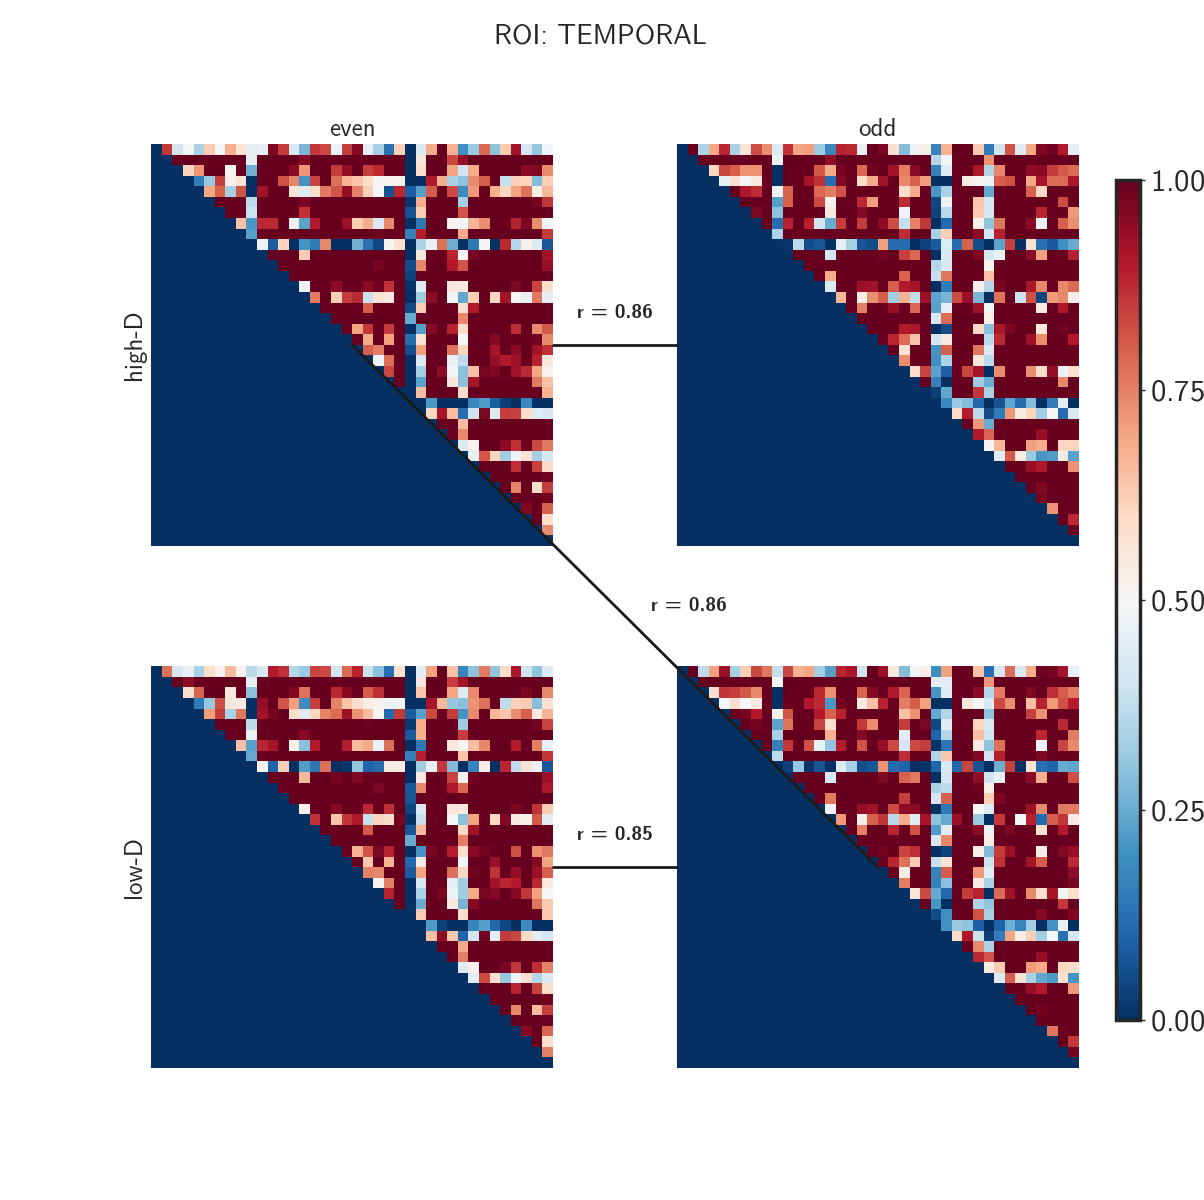

Completed processing for temporal
Processing ROI: ventral


/home/chan21/.conda/envs/bonner-libraries/lib/python3.11/site-packages/seaborn/utils.py:84: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.draw()
/home/chan21/.conda/envs/bonner-libraries/lib/python3.11/site-packages/seaborn/utils.py:84: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.draw()
/home/chan21/.conda/envs/bonner-libraries/lib/python3.11/site-packages/seaborn/utils.py:84: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.draw()
/home/chan21/.conda/envs/bonner-libraries/lib/python3.11/site-packages/seaborn/utils.py:84: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.draw()
/tmp/ipykernel_45893/405156537.py:196: UserWarning: This figure includes Axes that are not compatibl

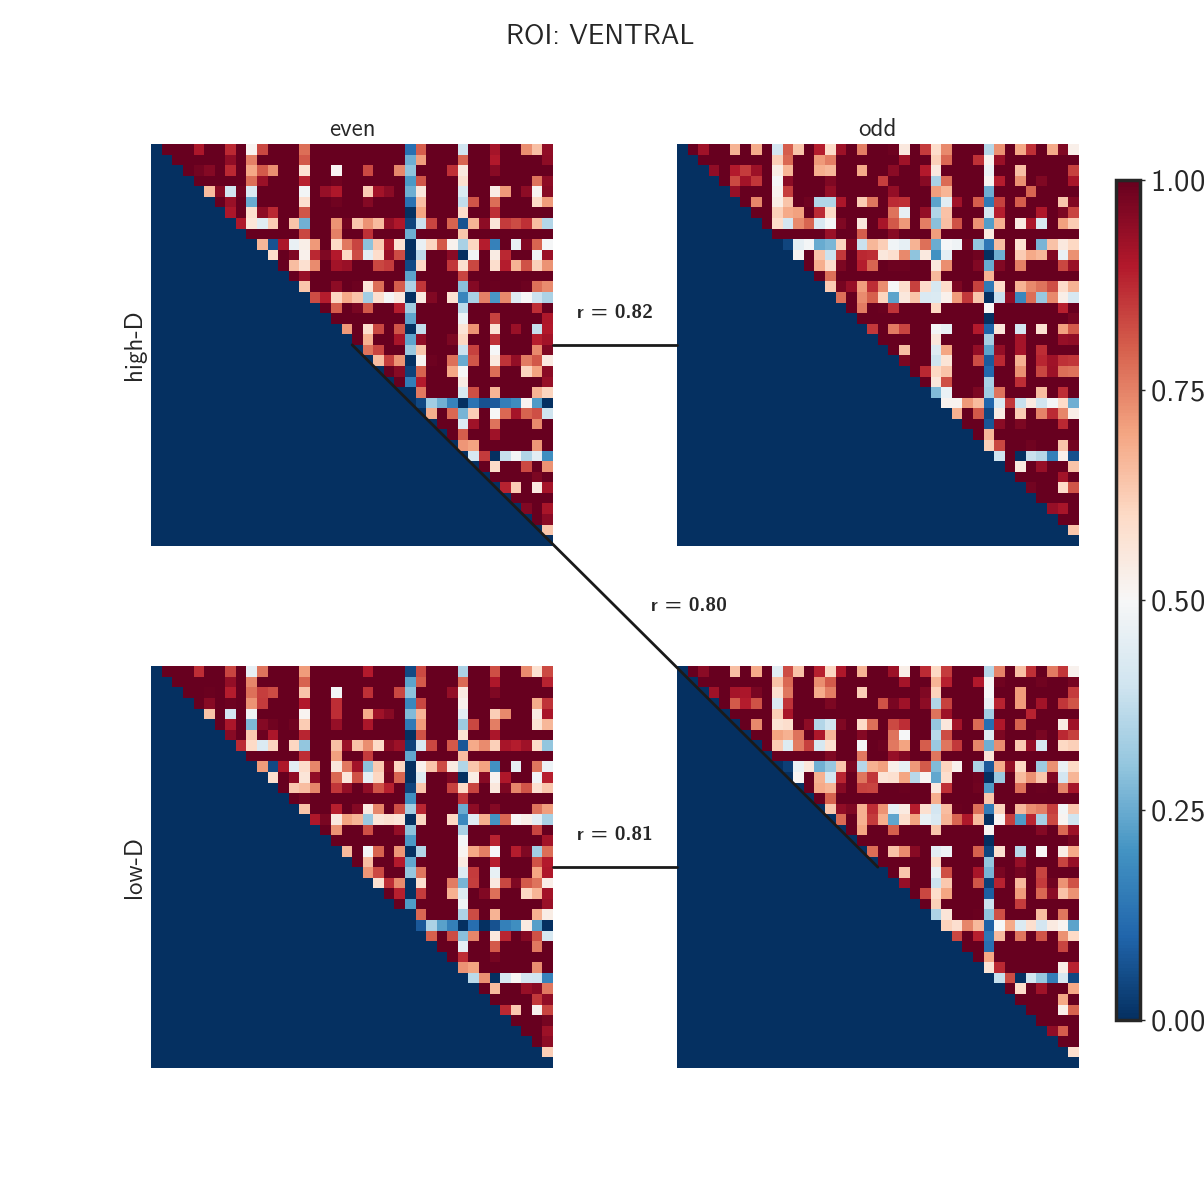

Completed processing for ventral
Processing ROI: semantic


/home/chan21/.conda/envs/bonner-libraries/lib/python3.11/site-packages/seaborn/utils.py:84: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.draw()
/home/chan21/.conda/envs/bonner-libraries/lib/python3.11/site-packages/seaborn/utils.py:84: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.draw()
/home/chan21/.conda/envs/bonner-libraries/lib/python3.11/site-packages/seaborn/utils.py:84: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.draw()
/home/chan21/.conda/envs/bonner-libraries/lib/python3.11/site-packages/seaborn/utils.py:84: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.draw()
/tmp/ipykernel_45893/405156537.py:196: UserWarning: This figure includes Axes that are not compatibl

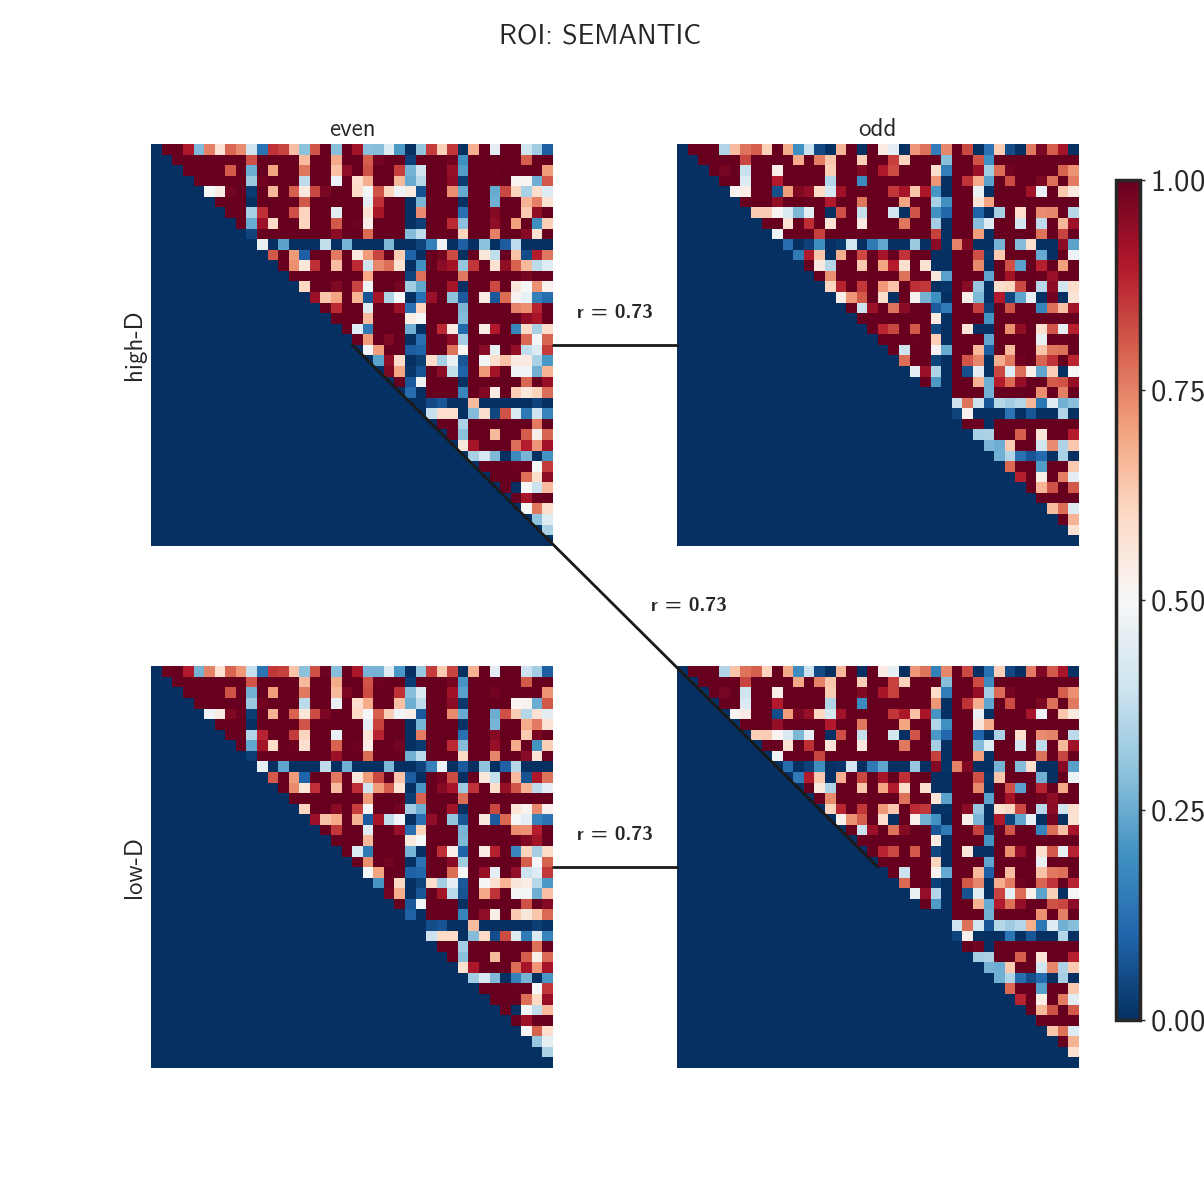

Completed processing for semantic


/home/chan21/.conda/envs/bonner-libraries/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/chan21/.conda/envs/bonner-libraries/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/chan21/.conda/envs/bonner-libraries/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_gro

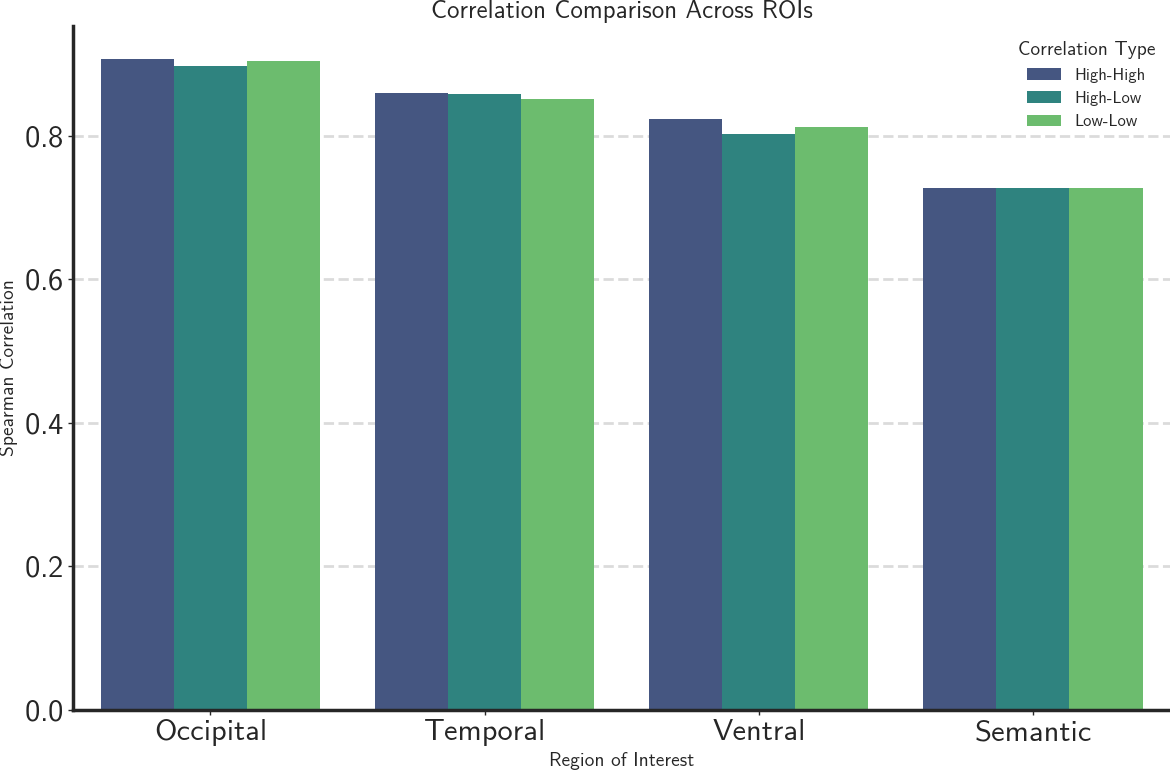

In [4]:
import sys
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import h5py
import itertools
from scipy.stats import spearmanr

# Path setup
notebook_dir = Path('/home/chan21/idim-debug-spectra/notebooks')
while not (notebook_dir / 'src').exists():
    notebook_dir = notebook_dir.parent
if str(notebook_dir) not in sys.path:
    sys.path.append(str(notebook_dir))

# Import project modules - using * imports as requested
from src.utils._config import *
from src.utils._io import *
from src.utils._paths import *
from src.spectra._definition import *
from src.utils.plot import *

# Set plotting style
plt.rcParams.update(DEFAULT_MATPLOTLIBRC)
sns.set_theme(style="ticks", rc=DEFAULT_MATPLOTLIBRC, context="poster")

# Define ROIs and data paths
rois = ['occipital', 'temporal', 'ventral', 'semantic']
base_results_path = Path('/home/chan21/idim-debug-spectra/results/')
movies = ['iteration', 'defeat', 'growth', 'lemonade']

# Dictionary to store results for all ROIs
all_roi_correlations = {}

def get_upper_triangle(matrix):
    """Extract upper triangle values from a matrix, excluding diagonal."""
    mask = np.triu_indices(matrix.shape[0], k=1)
    return matrix[mask]

def load_matrices(base_path, roi, is_isc=False):
    """Load matrices from HDF5 files for a specific ROI.
    
    Args:
        base_path: Base path for results
        roi: Region of interest (occipital, temporal, ventral, semantic)
        is_isc: Whether to load ISC matrices
        
    Returns:
        Dictionary of matrices for each movie
    """
    # Load configuration for this ROI
    recon_path = base_path / f"recon_{roi}_functional"
    config = AnalysisConfig.from_yaml(recon_path / "config.yaml")
    subjects = config.subjects
    
    matrices = {}
    
    if is_isc:
        h5_path = base_path / f"isc_{roi}_functional/eigenspectra.h5"
        for movie in movies:
            matrix = np.zeros((len(subjects), len(subjects)))
            with h5py.File(h5_path, 'r') as h5f:
                for i, i_subject in enumerate(subjects):
                    for j, j_subject in enumerate(subjects[i+1:], i+1):
                        key = f"data/{i_subject}_{j_subject}_{movie}"
                        if key in h5f:
                            value = h5f[key]['observed'][()]
                            matrix[i, j] = value.mean() if isinstance(value, np.ndarray) else value
            matrices[movie] = np.triu(matrix, k=1)
    else:
        pairwise_subjects = list(itertools.combinations(subjects, 2))
        for movie in movies:
            matrix = np.zeros((len(subjects), len(subjects)))
            for target_subjects in pairwise_subjects:
                h5_path = recon_path / f'eigenspectra_{target_subjects[0]}_{target_subjects[1]}.h5'
                with h5py.File(h5_path, 'r') as h5f:
                    i = subjects.index(target_subjects[0])
                    j = subjects.index(target_subjects[1])
                    key = f"data/{target_subjects[0]}_{target_subjects[1]}_{movie}"
                    if key in h5f:
                        value = h5f[key]['observed'][()]
                        matrix[i, j] = value.mean() if isinstance(value, np.ndarray) else value
            matrices[movie] = np.triu(matrix, k=1)
    
    return matrices, subjects

# Create even/odd splits
even_movies = movies[::2]  # iteration, growth
odd_movies = movies[1::2]  # defeat, lemonade

# Average and normalize matrices
def process_split_matrices(matrices_dict, movie_indices):
    """Average and z-score matrices for given movie indices."""
    avg_matrix = np.nanmean([matrices_dict[movies[i]] for i in movie_indices], axis=0)
    return (avg_matrix - avg_matrix.mean()) / avg_matrix.std()

def process_roi(roi):
    """Process data for a specific ROI.
    
    Args:
        roi: Name of the ROI to process
        
    Returns:
        Dictionary of matrices and correlations, subjects list
    """
    print(f"Processing ROI: {roi}")
    
    # Load matrices for this ROI
    matrices, subjects = load_matrices(base_results_path, roi)
    matrices_isc, _ = load_matrices(base_results_path, roi, is_isc=True)
    
    # Process matrices for each split
    matrices_even = process_split_matrices(matrices, [0, 2])  # iteration, growth
    matrices_odd = process_split_matrices(matrices, [1, 3])   # defeat, lemonade
    matrices_isc_even = process_split_matrices(matrices_isc, [0, 2])
    matrices_isc_odd = process_split_matrices(matrices_isc, [1, 3])
    
    # Extract upper triangles for correlation
    triu_even = get_upper_triangle(matrices_even)
    triu_odd = get_upper_triangle(matrices_odd)
    triu_isc_even = get_upper_triangle(matrices_isc_even)
    triu_isc_odd = get_upper_triangle(matrices_isc_odd)
    
    # Calculate Spearman correlations
    correlations = {
        'high_even_high_odd': spearmanr(triu_isc_even, triu_isc_odd)[0],
        'high_even_low_odd': spearmanr(triu_isc_even, triu_odd)[0],
        'low_even_low_odd': spearmanr(triu_even, triu_odd)[0]
    }
    
    result = {
        'matrices_even': matrices_even,
        'matrices_odd': matrices_odd,
        'matrices_isc_even': matrices_isc_even,
        'matrices_isc_odd': matrices_isc_odd,
        'correlations': correlations
    }
    
    return result, subjects

# Create visualization
def plot_correlation_matrices(roi_data, subjects, roi_name):
    """Create correlation matrices visualization with connecting lines.
    
    Args:
        roi_data: Dictionary containing matrices and correlations
        subjects: List of subjects
        roi_name: Name of the ROI for title
        
    Returns:
        Matplotlib figure
    """
    fig, axes = plt.subplots(2, 2, figsize=(12, 12), gridspec_kw={'wspace': 0.3, 'hspace': 0.3})
    
    # Define colormap
    cmap = plt.cm.RdBu_r
    vmin, vmax = 0, 1
    
    # Extract data
    matrices_isc_even = roi_data['matrices_isc_even']
    matrices_isc_odd = roi_data['matrices_isc_odd']
    matrices_even = roi_data['matrices_even']
    matrices_odd = roi_data['matrices_odd']
    correlations = roi_data['correlations']
    
    # Plot heatmaps
    matrices_to_plot = [
        [matrices_isc_even, matrices_isc_odd],  # Top row (high-D)
        [matrices_even, matrices_odd]           # Bottom row (low-D)
    ]
    
    for i in range(2):
        for j in range(2):
            sns.heatmap(matrices_to_plot[i][j], ax=axes[i, j], cmap=cmap, 
                        vmin=vmin, vmax=vmax, square=True, cbar=False)
            axes[i, j].set_xticks([])
            axes[i, j].set_yticks([])
    
    # Add row and column labels
    axes[0, 0].set_ylabel('high-D', fontsize=18)
    axes[1, 0].set_ylabel('low-D', fontsize=18)
    axes[0, 0].set_title('even', fontsize=18)
    axes[0, 1].set_title('odd', fontsize=18)
    
    # Add main title for the ROI
    fig.suptitle(f"ROI: {roi_name.upper()}", fontsize=20, y=0.98)
    
    # Add colorbar
    cbar_ax = fig.add_axes([0.93, 0.15, 0.02, 0.7])
    cb = plt.colorbar(plt.cm.ScalarMappable(norm=plt.Normalize(vmin=vmin, vmax=vmax), cmap=cmap), 
                     cax=cbar_ax)
    cb.set_ticks([0.00, 0.25, 0.50, 0.75, 1.00])
    
    # Apply tight layout
    plt.tight_layout(rect=[0, 0, 0.9, 0.92])
    
    # Get axis positions for drawing lines
    ax_pos = [[ax.get_position() for ax in row] for row in axes]
    
    # Create a separate axes for drawing lines
    line_ax = fig.add_axes([0, 0, 1, 1], frameon=False)
    line_ax.set_xlim(0, 1)
    line_ax.set_ylim(0, 1)
    line_ax.axis('off')
    
    # Draw connecting lines and add correlation labels
    # Top horizontal line (high-even to high-odd)
    mid_x_top = (ax_pos[0][0].x1 + ax_pos[0][1].x0) / 2
    mid_y_top = ax_pos[0][0].y0 + ax_pos[0][0].height/2
    line_ax.plot(
        [ax_pos[0][0].x1, ax_pos[0][1].x0], 
        [mid_y_top, mid_y_top],
        'k-', linewidth=2
    )
    fig.text(mid_x_top, mid_y_top + 0.02, f"r = {correlations['high_even_high_odd']:.2f}", 
            ha='center', va='bottom', fontsize=14, fontweight='bold')
    
    # Bottom horizontal line (low-even to low-odd)
    mid_x_bottom = (ax_pos[1][0].x1 + ax_pos[1][1].x0) / 2
    mid_y_bottom = ax_pos[1][0].y0 + ax_pos[1][0].height/2
    line_ax.plot(
        [ax_pos[1][0].x1, ax_pos[1][1].x0], 
        [mid_y_bottom, mid_y_bottom],
        'k-', linewidth=2
    )
    fig.text(mid_x_bottom, mid_y_bottom + 0.02, f"r = {correlations['low_even_low_odd']:.2f}", 
            ha='center', va='bottom', fontsize=14, fontweight='bold')
    
    # Diagonal line (high-even to low-odd)
    mid_x_diag = (ax_pos[0][0].x0 + ax_pos[0][0].width/2 + ax_pos[1][1].x0 + ax_pos[1][1].width/2) / 2
    mid_y_diag = (ax_pos[0][0].y0 + ax_pos[0][0].height/2 + ax_pos[1][1].y0 + ax_pos[1][1].height/2) / 2
    line_ax.plot(
        [ax_pos[0][0].x0 + ax_pos[0][0].width/2, ax_pos[1][1].x0 + ax_pos[1][1].width/2], 
        [ax_pos[0][0].y0 + ax_pos[0][0].height/2, ax_pos[1][1].y0 + ax_pos[1][1].height/2],
        'k-', linewidth=2
    )
    fig.text(mid_x_diag + 0.03, mid_y_diag, f"r = {correlations['high_even_low_odd']:.2f}", 
            ha='left', va='center', fontsize=14, fontweight='bold')
    
    return fig

def plot_summary_barplot(all_correlations):
    """Create a bar plot comparing correlations across all ROIs.
    
    Args:
        all_correlations: Dictionary of correlation results for each ROI
        
    Returns:
        Matplotlib figure
    """
    # Prepare data for plotting
    corr_types = ['high_even_high_odd', 'high_even_low_odd', 'low_even_low_odd']
    corr_labels = ['High-High', 'High-Low', 'Low-Low']
    
    # Create a DataFrame for easier plotting
    import pandas as pd
    plot_data = []
    
    for roi in rois:
        for corr_type, corr_label in zip(corr_types, corr_labels):
            plot_data.append({
                'ROI': roi.capitalize(),
                'Correlation Type': corr_label,
                'Correlation (r)': all_correlations[roi]['correlations'][corr_type]
            })
    
    df = pd.DataFrame(plot_data)
    
    # Create the bar plot
    plt.figure(figsize=(12, 8))
    
    # Use seaborn for a nicer bar plot
    ax = sns.barplot(
        x='ROI', 
        y='Correlation (r)', 
        hue='Correlation Type', 
        data=df,
        palette='viridis'
    )
    
    # Add title and labels
    plt.title('Correlation Comparison Across ROIs', fontsize=18)
    plt.xlabel('Region of Interest', fontsize=14)
    plt.ylabel('Spearman Correlation', fontsize=14)
    
    # Adjust legend
    plt.legend(title='Correlation Type', fontsize=12, title_fontsize=14)
    
    # Add grid for easier reading
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Ensure all labels are visible
    plt.tight_layout()
    
    return plt.gcf()

# Process each ROI and collect results
for roi in rois:
    roi_data, subjects = process_roi(roi)
    all_roi_correlations[roi] = roi_data
    
    # Generate and save the correlation matrix plot for this ROI
    fig = plot_correlation_matrices(roi_data, subjects, roi)
    #plt.savefig(f'correlation_matrices_{roi}.png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close(fig)
    
    print(f"Completed processing for {roi}")

# Generate summary bar plot
summary_fig = plot_summary_barplot(all_roi_correlations)
plt.show()
#plt.savefig('correlation_summary_barplot.png', dpi=300, bbox_inches='tight')


SyntaxError: invalid syntax (1079586330.py, line 608)